Import relevant libraries and classes.

In [1]:
import matplotlib.pyplot as plt
import nsidc_dataviewer_utils as utils
import numpy as np
from datetime import datetime, timedelta
from matplotlib import animation
from IPython.display import HTML

## Variables

Here's where all of your config happens. Change these variables to change how the animation looks and how fast it goes.

This is a list of all of the different places where data can be accessed from. Change the number in CURRENT_SOURCE to point to a different location.

In [2]:
utils.pretty_print_sources("0051")

NSIDC_0051_SOUTH_STAGING_URL_FORMAT = /disks/sidads_staging/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/south/daily/{yyyy}/nt_{yymmdd}_f17_v1.1_s.bin

NSIDC_0051_NORTH_URL_FORMAT = /projects/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/north/daily/{yyyy}/nt_{yymmdd}_f17_v1.1_n.bin

NSIDC_0051_SOUTH_URL_FORMAT = /projects/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/south/daily/{yyyy}/nt_{yymmdd}_f17_v1.1_s.bin

NSIDC_0051_NORTH_STAGING_URL_FORMAT = /disks/sidads_staging/DATASETS/nsidc0051_ gsfc_nasateam_seaice/final-gsfc/north/daily/{yyyy}/nt_{yymmdd}_f17_v1.1_n.bin



In [3]:
SOURCES = utils.get_sources("0051")
CURRENT_SOURCE = SOURCES[1]
print(CURRENT_SOURCE)

/projects/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/south/daily/{yyyy}/nt_{yymmdd}_f17_v1.1_s.bin


This is the start date and end date for the animation. The script will skip over files that don't exist.

In [4]:
TIMEFRAME = (datetime(2015, 1, 1), datetime(2015, 12, 31))

This is the framerate for the animation. `interval` refers to the time between frames, in MS. 50-100 is recommended.

In [5]:
INTERVAL = 100

Use this parameter to change the coloring of the map generated. `"Blues"` generates a bluescale on white background, `"jet"` is yellow/green on a red background, `"terrain_r"` is blue/green on white background, and `"winter"` is green on blue background. The other ones you might have to try for yourself.

In [6]:
utils.pretty_print_colormaps()

Blues
jet
terrain_r
winter
gist_ncar
rainbow
magma
prism
spectral
cool
gist_earth_r


In [7]:
COLORMAPS = utils.get_colormaps()
CURRENT_COLORMAP = COLORMAPS[2]

The size of the array exists as two byte values in each binary file. These can be different across datasets. For 0051, rows start at byte 7, and cols start at byte 13.

In [8]:
ROWS_START = 7
COLS_START = 13

These parameters refer to the width and height of the animation. Larger animation means longer render times.

In [9]:
ANIMATION_WIDTH = 5
ANIMATION_HEIGHT = 5

Finally, use this variable to toggle log messages. (True/False, case sensitive)

In [10]:
VERBOSE = True

These are some constants and helper methods.

Rendering data for 2015-01-01 00:00:00
Rendering data for 2015-01-01 00:00:00
Rendering data for 2015-01-02 00:00:00
Rendering data for 2015-01-03 00:00:00
Rendering data for 2015-01-04 00:00:00
Rendering data for 2015-01-05 00:00:00
Rendering data for 2015-01-06 00:00:00
Rendering data for 2015-01-07 00:00:00
Rendering data for 2015-01-08 00:00:00
Rendering data for 2015-01-09 00:00:00
Rendering data for 2015-01-10 00:00:00
Rendering data for 2015-01-11 00:00:00
Rendering data for 2015-01-12 00:00:00
Rendering data for 2015-01-13 00:00:00
Rendering data for 2015-01-14 00:00:00
Rendering data for 2015-01-15 00:00:00
Rendering data for 2015-01-16 00:00:00
Rendering data for 2015-01-17 00:00:00
Rendering data for 2015-01-18 00:00:00
Rendering data for 2015-01-19 00:00:00
Rendering data for 2015-01-20 00:00:00
Rendering data for 2015-01-21 00:00:00
Rendering data for 2015-01-22 00:00:00
Rendering data for 2015-01-23 00:00:00
Rendering data for 2015-01-24 00:00:00
Rendering data for 2015-0

Rendering data for 2015-01-01 00:00:00


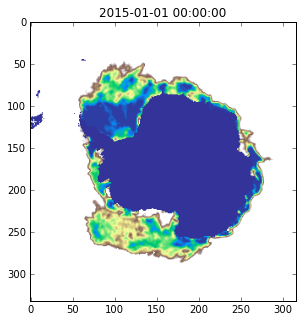

In [11]:
%matplotlib inline

plt.rcParams['animation.writer']= 'avconv'

def setup():
    global dsl
    dates_array = utils.generate_dates_array(TIMEFRAME)
    dsl = len(dates_array)
    dataset_shape = utils.get_current_dataset_shape(utils.form_uri(CURRENT_SOURCE, TIMEFRAME[0]), COLS_START, ROWS_START)
    constants_dict = {'cs':CURRENT_SOURCE,
                      'da':dates_array,
                      'ds':dataset_shape,
                      'v':VERBOSE,
                      'sb':0,
                      'p':plt,
                      'png':False,
                      'rng':False,
                      'cc':CURRENT_COLORMAP}
    utils.const.set_constants(**constants_dict)
    
setup()

fig = plt.figure(figsize=(ANIMATION_WIDTH, ANIMATION_HEIGHT))
anim = animation.FuncAnimation(fig, 
                               utils.render, 
                               frames=dsl, 
                               interval=INTERVAL, 
                               repeat=True)
HTML(anim.to_html5_video())